In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from prophet import Prophet

/usr/local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [3]:
# 1) Synthetic time series 생성 (changepoint + monthly seasonality + noise)
np.random.seed(42)
length = 200
dates = pd.date_range('2020-01-01', periods=length, freq='D')
t = np.arange(length)
trend = np.piecewise(
    t,
    [t < 60, (t >= 60) & (t < 130), t >= 130],
    [lambda x: 0.2 * x,
     lambda x: 0.2 * 60 + 0.5 * (x - 60),
     lambda x: 0.2 * 60 + 0.5 * 70 - 0.1 * (x - 130)]
)
season = 5 * np.sin(2 * np.pi * t / 30)
noise  = np.random.normal(0, 1, size=length)
y = trend + season + noise

# 학습/테스트 분할
train_len = 150
y_train, y_test = y[:train_len], y[train_len:]
dates_train = dates[:train_len]
dates_test  = dates[train_len:]

In [4]:
# 2) LSTM 데이터 준비
def create_dataset(series, window):
    Xs, Ys = [], []
    for i in range(len(series) - window):
        Xs.append(series[i:i+window])
        Ys.append(series[i+window])
    return np.array(Xs), np.array(Ys)

window = 30
X_raw, Y_raw = create_dataset(y_train, window)

def to_loader(X, Y, batch_size=16):
    X_t = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)
    Y_t = torch.tensor(Y, dtype=torch.float32).unsqueeze(-1)
    return DataLoader(TensorDataset(X_t, Y_t), batch_size=batch_size, shuffle=True)

loader_raw = to_loader(X_raw, Y_raw)

In [5]:
# 3) LSTM 모델 정의
class LSTMModel(nn.Module):
    def __init__(self, hidden_size=16):
        super().__init__()
        self.lstm = nn.LSTM(1, hidden_size, num_layers=1, batch_first=True)
        self.fc   = nn.Linear(hidden_size, 1)
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

In [6]:
# 4) LSTM 학습 (raw)
model_raw = LSTMModel(hidden_size=32)
opt_raw   = torch.optim.Adam(model_raw.parameters(), lr=0.005)
loss_fn   = nn.MSELoss()

for epoch in range(200):
    for xb, yb in loader_raw:
        opt_raw.zero_grad()
        loss_fn(model_raw(xb), yb).backward()
        opt_raw.step()

In [7]:
# 5) 테스트 구간 raw LSTM 예측 (iterative)
simple_preds = []
seq = y_train.copy()
for _ in range(len(y_test)):
    xin = torch.tensor(seq[-window:], dtype=torch.float32).unsqueeze(0).unsqueeze(-1)
    with torch.no_grad():
        p = model_raw(xin).item()
    simple_preds.append(p)
    seq = np.append(seq, p)

simple_preds = np.array(simple_preds)  # shape (50,)

In [8]:
# 6) 학습구간 raw LSTM 직접 예측(Direct one‐step) → residual 계산
with torch.no_grad():
    X_train_t = torch.tensor(X_raw, dtype=torch.float32).unsqueeze(-1)
    train_raw_preds = model_raw(X_train_t).squeeze().numpy()  # shape (150-window,)

# residual for Prophet
residual_train = Y_raw - train_raw_preds
dates_res_train = dates_train[window:]  # 대응하는 날짜 배열

In [9]:
# 7) Prophet 으로 residual 보완
df_res = pd.DataFrame({'ds': dates_res_train, 'y': residual_train})
m_res = Prophet(daily_seasonality=False,
                weekly_seasonality=True,
                yearly_seasonality=False,
                changepoint_prior_scale=0.1,
                seasonality_prior_scale=5)
m_res.add_seasonality(name='monthly', period=30.5, fourier_order=8)
m_res.fit(df_res)

# residual을 테스트 구간 날짜에 대해 예측
df_res_test = pd.DataFrame({'ds': dates_test})
forecast_res = m_res.predict(df_res_test)
res_pred_test = forecast_res['yhat'].values       # shape (50,)

07:02:39 - cmdstanpy - INFO - Chain [1] start processing
07:02:39 - cmdstanpy - INFO - Chain [1] done processing


In [10]:
# 8) Hybrid 최종 예측 = raw LSTM + Prophet(residual)
hybrid_preds = simple_preds + res_pred_test

# 9) 성능 비교
mse_simple = np.mean((y_test - simple_preds)**2)
mse_hybrid = np.mean((y_test - hybrid_preds)**2)
print(f"MSE Simple LSTM     : {mse_simple:.3f}")
print(f"MSE Hybrid LSTM+Prophet: {mse_hybrid:.3f}")

MSE Simple LSTM     : 37.136
MSE Hybrid LSTM+Prophet: 37.203


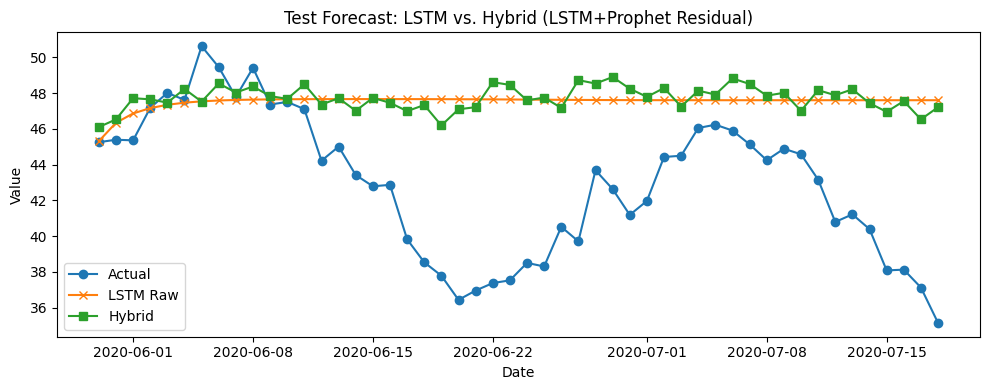

In [11]:
# 10) 결과 시각화
plt.figure(figsize=(10,4))
plt.plot(dates_test, y_test,      label='Actual',   marker='o')
plt.plot(dates_test, simple_preds, label='LSTM Raw', marker='x')
plt.plot(dates_test, hybrid_preds, label='Hybrid',   marker='s')
plt.legend()
plt.title("Test Forecast: LSTM vs. Hybrid (LSTM+Prophet Residual)")
plt.xlabel("Date")
plt.ylabel("Value")
plt.tight_layout()
plt.show()